# 546 (Optimization for Learning and Control) hw0

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.

You are welcome to use analytical and numerical computational tools; if you do, include the **commented** sourcecode in your writeup (e.g. the .ipynb file).

You are welcome to consult research articles and other materials; if you do, include a full citation in your writeup (e.g. the .ipynb file) and upload a .pdf of the article to Canvas alongside your homework submission.

## linear quadratic regulator

Consider the discrete-time linear quadratic regulator problem (DT-LQR)

$$\min_u c_\tau (x,u) \ \text{s.t.} \ x_{s+1} = A_s x_s + B_s u_s,$$
$$c_\tau(x,u) = \frac{1}{2} x_t^T P_t x_t + \frac{1}{2}\sum_{s=\tau}^{t-1} x_s^T Q_s x_s + u_s^T R_s u_s$$

where $P_t$, $\{Q_s\}_{s=\tau}^{t-1}$, $\{R_s\}_{s=\tau}^{t-1}$ are given symmetric positive-definite matrices.

In this problem, you'll apply Bellman's dynamic programming principle to determine the optimal control, then verify this control is the same one obtained by a descent algorithm.

a. Determine the optimal control and value at time $\tau = t$ (i.e. minimize $c_t$ with respect to $u_t$, and let $v^*_t = c_t(x^*,u^*)$ denote the optimal value that can be obtained at time $t$).

For $\tau = t$ the optimal control can be any thing, since optimal control $u^*_t$ determine the system state at $t+1$ which we don't care about. And the cost is the current system state value $v_t^* = \frac{1}{2} x_t^T P_t x_t$

b. Determine the optimal control and value at time $\tau = t-1$ (i.e. minimize $c_{t-1}$ with respect to $u_{t-1}$, and let $v^*_{t-1} = c_{t-1}(x^*,u^*)$ denote the optimal value that can be obtained at time $t-1$).

At time $\tau = t-1$, cost can be found:
$$J_{t-1} = \frac{1}{2} x^T_t P_t x_t + \frac{1}{2}x^T_{t-1} Q_{t-1} x_{t-1} + \frac{1}{2}u^T_{t-1} R_{t-1} u_{t-1}$$
with system constrain:
$$x_t = A_{t-1} x_{t-1} + B_{t-1}u_{t-1}$$

Applying nonlinear programming:

$D_{u_{t-1}} c_{t-1} = u^T_{t-1} R_{t-1} + x^T_t P(D_{u_{t-1}} x_t)$

$u^*_{t-1} = -(B^T_{t-1} P_t B_{t-1} + R_{t-1})^{-1} B_{t-1}^T P_t A_{t-1} x_{t-1}$

where the second derivative of the cost function needs to be positive:

$D_{u_{t-1}}^2 c_{t-1} = R_{t-1} +B_{t-1}^T P_t B_{t-1} > 0$

Then for cost in $\tau = t-1$:
$$v_{t-1}^* = \frac{1}{2} x_{t-1}^T P_{t-1} x_{t-1}$$

c. Note that the optimal control is linear in state and the optimal value is quadratic in state (i.e. determine $K_{t-1}$ and $P_{t-1}$ such that $u_{t-1} = K_{t-1} x_{t-1}$ and $v^*_{t-1} = c_{t-1}(x^*,u^*) = x_{t-1}^T P_{t-1} x_{t-1}$).

As we've calculated the optimal control for $\tau = t-1$ above:
$$K_{t-1} = -(B_{t-1}^T P_{t} B_{t-1} + R_{t-1})^{-1} B_{t-1}^T P_{t-1} A_{t-1}$$
$$P_{t-1} = (A_{t-1} - B_{t-1} K_{t-1})^T P{t} (A_{t-1} - B_{t-1} K_{t-1}) + K_{t-1}^T R_{t-1} K_{t-1} + Q_{t-1}$$

d. Use the substitution in (c.) to generalize the calculation in (b.) to derive a recursive formula to compute the optimal control and value at any time $s\in [\tau,t]$.

For each time step $s \in [\tau,t]$ in a trajectory:

$$u_s^* = -K_s x_s$$
$$J_s^* = \frac{1}{2} x_s^T P_s x_s$$
$$-K_s = (B_s^T P_{s+1} B_s + R_s)^{-1} B_s^T P_{s+1} A_s$$
$$P_s = (A_s - B_s K_s)^T P_{s+1} (A_s - B_s K_s) + K_s^T R_s K_s + Q_s$$

e. Implement the recursion in (d.) numerically for the following system, which is a discretized linear spring-mass-damper (let $\kappa,\beta,q,r,\Delta > 0$ be parameters that you can easily vary in your implementation):

$$A^\Delta = I + \Delta \left[\begin{array}{cc} 0 & 1 \\ -\kappa & -\beta \end{array}\right],\ B^\Delta = \Delta \left[\begin{array}{c} 0 \\ 1 \end{array}\right],\ P_t = 0,\ Q^\Delta_s = q \cdot \Delta \cdot I,\ R^\Delta_s = r \cdot \Delta \cdot I.$$

In [38]:
import numpy as np
import math
import numpy.linalg as la
import scipy.linalg as sla
import matplotlib.pyplot as plt
import _547 as lst
import control as ctrl
%matplotlib inline



import scipy as sp

from _547 import *

In [6]:
tri, k, b, q, r = 0.1, 1.0, 1.0, 1.0, 1.0
t0 = 1
tf = 10
dt = 1

#this function is modified from Prof. Sam Burden's EE548 lecture example
def LQR(A,B,Q,R,Pt,tf, dt=1e-4):
    t = 0.0
    K = []
    P = []
    while t < tf:
        Pi = sla.solve_continuous_are(A(tri, k, b, q, r),B(tri, k, b, q, r),\
                                      Q(tri, k, b, q, r),R(tri, k, b, q, r));
        K.append(np.dot(la.inv(R(tri, k, b, q, r)), np.dot(B(tri, k, b, q, r).T,Pi)));
        P.append(Pi);
        t += dt;
    K.append(np.dot(la.inv(R(tri, k, b, q, r)), np.dot(B(tri, k, b, q, r).T,Pt)))
    P.append(Pt)
    return np.asarray(K), np.asarray(P)

In [7]:
A = lambda tri, k, b, q, r : np.identity(2) + np.dot(tri, np.array([[0.0,1.0],[-k,-b]]))
B = lambda tri, k, b, q, r : np.dot(tri, np.array([[0],[1]]))
Q = lambda tri, k, b, q, r : np.dot(q*tri, np.identity(2))
R = lambda tri, k, b, q, r : np.dot(r*tri, np.identity(1))
Pt = np.zeros((2,2));
K,P = LQR(A,B,Q,R,Pt,10,1)

def u_out(t,x):
    return -np.dot(K[int(t/dt)],x)

def f(t,x,u):
    return np.dot(A(tri, k, b, q, r),x) + np.dot(B(tri, k, b, q, r),u)

def springMassCost(x,u):
    J = 0.0
    for i in range(len(x[:,0])):
        J += .5*np.dot(np.dot(x[i,:].transpose(),P[i]), x[i,:])
    return J

x0 = np.asarray([1.0,0.0]) #Initial condition
t_spring,x_spring,u_spring = lst.forward_euler(f=f,t=tf,x=x0,utx=u_out,dt=dt,return_u=True)
u_spring = np.append(u_spring,[0.0])

print ('Actual Cost')
print (springMassCost(x_spring,u_spring))

Actual Cost
17025.88968990471


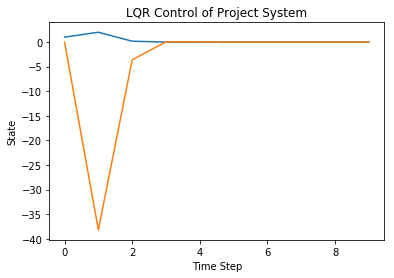

In [8]:
plt.plot(x_spring[:,0])
plt.plot(x_spring[:,1])
plt.title('LQR Control of Project System')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

In [9]:
x0 = np.asarray([0.0,1.0]) #Initial condition
t_spring,x_spring,u_spring = lst.forward_euler(f=f,t=tf,x=x0,utx=u_out,dt=dt,return_u=True)
u_spring = np.append(u_spring,[0.0])

print ('Actual Cost')
print (springMassCost(x_spring,u_spring))

Actual Cost
52.32672860886469


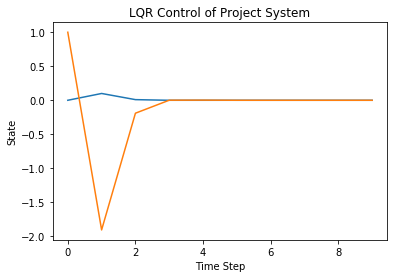

In [10]:
plt.plot(x_spring[:,0])
plt.plot(x_spring[:,1])
plt.title('LQR Control of Project System')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

f. Verify your implementation in (e.) by performing gradient descent to approximate the optimal input on time horizon $t = 10\cdot\Delta$ and $t = 100\cdot\Delta$ for the following initial conditions with $\kappa,\beta,q,r = 1$, $\Delta = 0.1$:

$$x_1 = (1,0),\ x_2 = (0,1).$$

Unfortunately, the gradient descent algorithm I run here diverages my system instead of converge it. And the bug was not found prior to the submission..

In [173]:
# from Prf. Sam Burden's EE548 lecture example
def steepest_descent(u,x,J=None,DJ=None,a=0.001):
  """
  execute one step of steepest descent:

    u' = u - a * DJ(u) 

  input:
    u - m array - base point
    J : R^m --> R - objective 
    (optional:)
    DJ : R^m --> R^m - gradient
    a  : (J,u,d) |--> scalar  - stepsize 

  output:
    u - a * DJ(u)
  """
  if DJ is None:
      assert J is not None, "J must be provided if DJ isn't"
      DJ = lambda u_ : D(J,u_)
  DJu = DJ(u,x)
  assert DJu.size == u.size, 'DJ(u) has size m = u.size'
  DJu.shape = (u.size,)
  return u - a * DJu # steepest descent step

'''
DJ = lambda u,x : np.dot(np.dot(np.dot(A(tri, k, b, q, r),x).transpose(), Pt),B(tri, k, b, q, r)) +\
                    np.dot(u.transpose(), R(tri, k, b, q, r) + np.dot(np.dot(B(tri, k, b, q, r), Pt),\
                                                                      B(tri, k, b, q, r)))
                                                          '''
'''
def DJ(u,x):
    return np.dot(np.dot(np.dot(A(tri, k, b, q, r),x).transpose(), Pt),B(tri, k, b, q, r)) +\
            np.dot(u.transpose(), R(tri, k, b, q, r) + \
           np.dot(np.dot(B(tri, k, b, q, r).transpose(), Pt), B(tri, k, b, q, r)))
'''

def DJ(u,x):
    return np.dot(u.transpose(), R(tri, k, b, q, r)) +\
            np.dot(\
                   np.dot((np.dot(A(tri, k, b, q, r), x)+\
                           np.dot(B(tri, k, b, q, r), u)).transpose(),\
                          Pt),\
                   B(tri, k, b, q, r))



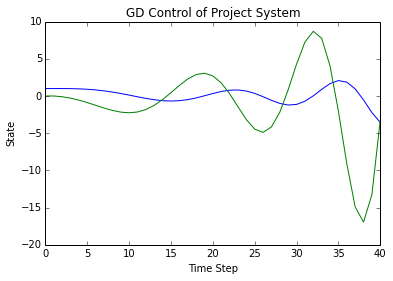

In [174]:
ui = [0.0]
xi = [1.0,0.0]
u_grad = [ui]
x_grad = [xi]
for k in range(40):
    u_grad.append(steepest_descent(np.asarray(u_grad[-1]),np.asarray(x_grad[-1]),DJ=DJ).tolist())
    x_grad.append(f(1, np.asarray(x_grad[-1]), np.asarray(u_grad[-1])).tolist())
    
u_grad = np.asarray(u_grad)
x_grad = np.asarray(x_grad)
    
plt.plot(x_grad[:,0])
plt.plot(x_grad[:,1])
plt.title('GD Control of Project System')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

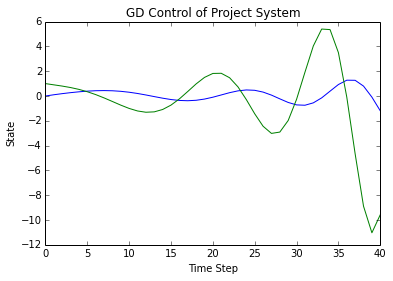

In [172]:
ui = [0.0]
xi = [0.0,1.0]
u_grad = [ui]
x_grad = [xi]
for k in range(40):
    u_grad.append(steepest_descent(np.asarray(u_grad[-1]),np.asarray(x_grad[-1]),DJ=DJ).tolist())
    x_grad.append(f(1, np.asarray(x_grad[-1]), np.asarray(u_grad[-1])).tolist())
    
u_grad = np.asarray(u_grad)
x_grad = np.asarray(x_grad)
    
plt.plot(x_grad[:,0])
plt.plot(x_grad[:,1])
plt.title('GD Control of Project System')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

g. Investigate how the optimal controls vary with respect to the ratio $q/r$ (i.e. let $q/r$ range from $0.1$ to $10$, compute the optimal control input, describe the trend you observe, and provide a visualization that clearly illustrates this trend).

As the program shown below, with the $q/r$ ratio increase, the total cost of the system increase.

In [193]:
q, r = 1.0, 10.0
tri, k, b = 0.1, 1.0, 1.0
t0 = 1
tf = 10
dt = 1

#this function is modified from Prof. Sam Burden's EE548 lecture example
def LQR(A,B,Q,R,Pt,tf, dt=1e-4):
    t = 0.0
    K = []
    P = []
    while t < tf:
        Pi = sla.solve_continuous_are(A(tri, k, b, q, r),B(tri, k, b, q, r),\
                                      Q(tri, k, b, q, r),R(tri, k, b, q, r));
        K.append(np.dot(la.inv(R(tri, k, b, q, r)), np.dot(B(tri, k, b, q, r).T,Pi)));
        P.append(Pi);
        t += dt;
    K.append(np.dot(la.inv(R(tri, k, b, q, r)), np.dot(B(tri, k, b, q, r).T,Pt)))
    P.append(Pt)
    return np.asarray(K), np.asarray(P)

A = lambda tri, k, b, q, r : np.identity(2) + np.dot(tri, np.array([[0.0,1.0],[-k,-b]]))
B = lambda tri, k, b, q, r : np.dot(tri, np.array([[0],[1]]))
Q = lambda tri, k, b, q, r : np.dot(q*tri, np.identity(2))
R = lambda tri, k, b, q, r : np.dot(r*tri, np.identity(1))
Pt = np.zeros((2,2));
K,P = LQR(A,B,Q,R,Pt,10,1)

def u_out(t,x):
    return -np.dot(K[int(t/dt)],x)

def f(t,x,u):
    return np.dot(A(tri, k, b, q, r),x) + np.dot(B(tri, k, b, q, r),u)

def springMassCost(x,u):
    J = 0.0
    for i in range(len(x[:,0])):
        J += .5*np.dot(np.dot(x[i,:].transpose(),P[i]), x[i,:])
    return J

x0 = np.asarray([1.0,0.0]) #Initial condition
t_spring,x_spring,u_spring = lst.forward_euler(f=f,t=tf,x=x0,utx=u_out,dt=dt,return_u=True)
u_spring = np.append(u_spring,[0.0])
print ('Actual Cost')
print (springMassCost(x_spring,u_spring))

Actual Cost
169137.665927


In [194]:
q, r = 1.0, 1.0
tri, k, b = 0.1, 1.0, 1.0
t0 = 1
tf = 10
dt = 1

#this function is modified from Prof. Sam Burden's EE548 lecture example
def LQR(A,B,Q,R,Pt,tf, dt=1e-4):
    t = 0.0
    K = []
    P = []
    while t < tf:
        Pi = sla.solve_continuous_are(A(tri, k, b, q, r),B(tri, k, b, q, r),\
                                      Q(tri, k, b, q, r),R(tri, k, b, q, r));
        K.append(np.dot(la.inv(R(tri, k, b, q, r)), np.dot(B(tri, k, b, q, r).T,Pi)));
        P.append(Pi);
        t += dt;
    K.append(np.dot(la.inv(R(tri, k, b, q, r)), np.dot(B(tri, k, b, q, r).T,Pt)))
    P.append(Pt)
    return np.asarray(K), np.asarray(P)

A = lambda tri, k, b, q, r : np.identity(2) + np.dot(tri, np.array([[0.0,1.0],[-k,-b]]))
B = lambda tri, k, b, q, r : np.dot(tri, np.array([[0],[1]]))
Q = lambda tri, k, b, q, r : np.dot(q*tri, np.identity(2))
R = lambda tri, k, b, q, r : np.dot(r*tri, np.identity(1))
Pt = np.zeros((2,2));
K,P = LQR(A,B,Q,R,Pt,10,1)

def u_out(t,x):
    return -np.dot(K[int(t/dt)],x)

def f(t,x,u):
    return np.dot(A(tri, k, b, q, r),x) + np.dot(B(tri, k, b, q, r),u)

def springMassCost(x,u):
    J = 0.0
    for i in range(len(x[:,0])):
        J += .5*np.dot(np.dot(x[i,:].transpose(),P[i]), x[i,:])
    return J

x0 = np.asarray([1.0,0.0]) #Initial condition
t_spring,x_spring,u_spring = lst.forward_euler(f=f,t=tf,x=x0,utx=u_out,dt=dt,return_u=True)
u_spring = np.append(u_spring,[0.0])
print ('Actual Cost')
print (springMassCost(x_spring,u_spring))

Actual Cost
17025.8896899


In [195]:
q, r = 10.0, 1.0
tri, k, b = 0.1, 1.0, 1.0
t0 = 1
tf = 10
dt = 1

#this function is modified from Prof. Sam Burden's EE548 lecture example
def LQR(A,B,Q,R,Pt,tf, dt=1e-4):
    t = 0.0
    K = []
    P = []
    while t < tf:
        Pi = sla.solve_continuous_are(A(tri, k, b, q, r),B(tri, k, b, q, r),\
                                      Q(tri, k, b, q, r),R(tri, k, b, q, r));
        K.append(np.dot(la.inv(R(tri, k, b, q, r)), np.dot(B(tri, k, b, q, r).T,Pi)));
        P.append(Pi);
        t += dt;
    K.append(np.dot(la.inv(R(tri, k, b, q, r)), np.dot(B(tri, k, b, q, r).T,Pt)))
    P.append(Pt)
    return np.asarray(K), np.asarray(P)

A = lambda tri, k, b, q, r : np.identity(2) + np.dot(tri, np.array([[0.0,1.0],[-k,-b]]))
B = lambda tri, k, b, q, r : np.dot(tri, np.array([[0],[1]]))
Q = lambda tri, k, b, q, r : np.dot(q*tri, np.identity(2))
R = lambda tri, k, b, q, r : np.dot(r*tri, np.identity(1))
Pt = np.zeros((2,2));
K,P = LQR(A,B,Q,R,Pt,10,1)

def u_out(t,x):
    return -np.dot(K[int(t/dt)],x)

def f(t,x,u):
    return np.dot(A(tri, k, b, q, r),x) + np.dot(B(tri, k, b, q, r),u)

def springMassCost(x,u):
    J = 0.0
    for i in range(len(x[:,0])):
        J += .5*np.dot(np.dot(x[i,:].transpose(),P[i]), x[i,:])
    return J

x0 = np.asarray([1.0,0.0]) #Initial condition
t_spring,x_spring,u_spring = lst.forward_euler(f=f,t=tf,x=x0,utx=u_out,dt=dt,return_u=True)
u_spring = np.append(u_spring,[0.0])
print ('Actual Cost')
print (springMassCost(x_spring,u_spring))

Actual Cost
18174.1013284


h. Compare the results from (e.)/(f.) with the results obtained from the solution to the continuous-time linear quadratic regulator (CT-LQR):

$$A = \frac{1}{\Delta} (A^\Delta - I),\ B = \frac{1}{\Delta} B^\Delta,\ Q = \frac{1}{\Delta} Q^\Delta,\ R = \frac{1}{\Delta} R^\Delta,$$

$$u^*_s = - K_s x_s,\ K_s = R^{-1} B^T P_s,$$

$$v^*_s = \frac{1}{2} x_s^T P_s x_s,\ \dot{P_s} = -(A^T P_s + P_s A - P_s B R^{-1} B^T P_s + Q).$$

Investigate how the comparison varies with respect to $\Delta$ (i.e. let $\Delta$ range from $\sim 10^0$ to $\sim 10^{-8}$ and plot the norm of the difference between the optimal inputs and values as a function of $\Delta$). 


From the experiment below we find that, smaller the $\Delta$ is, more accurate the simulation and solution will get. With small $\Delta$, the simulated trajectories are much smoother and solution is much effective.

In [55]:
def tvCTLQR(A,B,Q,R,Pt,tf,dt=1e-2):
    t_ = 0.0
    K = []
    P = []
    while t_ < tf:
        P_ = sla.solve_continuous_are(A(tri, k, b, q, r),B(tri, k, b, q, r),Q(tri, k, b, q, r),R(tri, k, b, q, r))
        K_ = np.dot(la.inv(R(tri, k, b, q, r )), np.dot(B(tri, k, b, q, r ).T,P_))
        K.append(K_)
        P.append(P_)
        t_ += dt
    K_ = np.dot(la.inv(R(tri, k, b, q, r )), np.dot(B(tri, k, b, q, r ).T,Pt))
    K.append(K_)
    P.append(Pt)
    return np.asarray(K),np.asarray(P)

Ac = lambda tri, k, b, q, r : 1/tri * (A(tri, k, b, q, r) - np.identity(2))
Bc = lambda tri, k, b, q, r : 1/tri * B(tri, k, b, q, r)
Qc = lambda tri, k, b, q, r : 1/tri * Q(tri, k, b, q, r)
Rc = lambda tri, k, b, q, r : 1/tri * R(tri, k, b, q, r)

x0 = np.asarray([1.0,0.0])
tf = 10
dt = 1e-3
K,P = tvCTLQR(Ac,Bc,Qc,Rc,Pt,tf,dt = dt)

Actual Cost
551.3083399552316


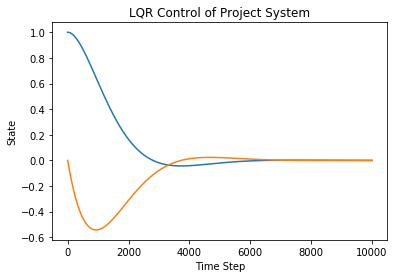

In [59]:
def u_c(t,x):
    return -np.dot(K[int(t/dt)],x)
    
def fc(t,x,u):
    return np.dot(Ac(tri, k, b, q, r),x) + np.dot(Bc(tri, k, b, q, r),u)

t_spring,x_spring,u_spring = forward_euler(f=fc,t=tf,x=x0,utx=u_c,dt=dt,return_u=True)
u_spring = np.append(u_spring,[0.0])

print ('Actual Cost')
print (springMassCost(x_spring,u_spring))
plt.plot(x_spring[:,0])
plt.plot(x_spring[:,1])
plt.title('LQR Control of Project System')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

Actual Cost
246.46798161123772


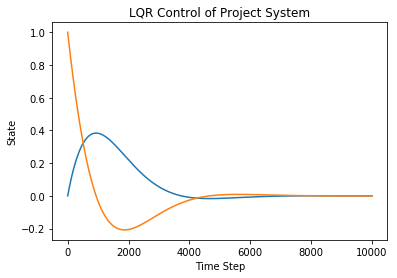

In [60]:
x0 = np.asarray([0.0,1.0])
t_spring,x_spring,u_spring = forward_euler(f=fc,t=tf,x=x0,utx=u_c,dt=dt,return_u=True)
u_spring = np.append(u_spring,[0.0])

print ('Actual Cost')
print (springMassCost(x_spring,u_spring))
plt.plot(x_spring[:,0])
plt.plot(x_spring[:,1])
plt.title('LQR Control of Project System')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

Actual Cost
1.9250887541697095


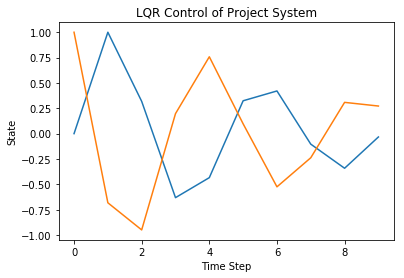

In [62]:
dt = 1
K,P = tvCTLQR(Ac,Bc,Qc,Rc,Pt,tf,dt = dt)
t_spring,x_spring,u_spring = forward_euler(f=fc,t=tf,x=x0,utx=u_c,dt=dt,return_u=True)
u_spring = np.append(u_spring,[0.0])

print ('Actual Cost')
print (springMassCost(x_spring,u_spring))
plt.plot(x_spring[:,0])
plt.plot(x_spring[:,1])
plt.title('LQR Control of Project System')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

**BONUS** show that the solution to (CT-LQR) can be obtained by taking the limit of the (DT-LQR) recursion from (d.)/(e.) as $\Delta \rightarrow 0$.

## application

a. Specify an optimal control problem for a system of your choosing (e.g. a system from the paper you plan to present or the project you plan to complete for the class).  Be precise:  provide the mathematical definitions for all symbols.  Also, be clear:  provide plain language explanations for what each symbol corresponds to in the application.

For my final project, I am planning to finish a portion of my master thesis project. In a part of my master thesis project, I am trying to implement a robotic system that play physical games with human. To simulate a human robot physical game play scenario, we purpose a catch and dodge game where a robot is holding some object, and the human adversary is trying to catch such object, meanwhile the robot is trying to dodge the adversary's hand.

Scoring:

The robot and the human adversary will keep a score for each of themself. The human player will get 1 points when he successfully touch the object (senser feedback enable). In front of the robot, the is a 3 dimension area that defined as robot scoring area, where the robot will get 1 points if the human's hand goes across this area (If the human touch the object after crossing the area boundary, human will not score). However, the robot's object holding griper should not be stay in (or stay behind) the scoring area for more then 10 seconds, otherwise 1 point off. Human only suppose to use one hand to attach.

Objective:

A policy needs to be trained to generate trajectories for the robot gripper to try to maximize robot's score and minimize human adversary's score (maximize the ratio of robot score over human score). 

System:

System State: (obj_pos, obj_qua, hand_pos, hand_qua)

"obj" denote the spacial information of the object as well as robot's object holding gripper, and "hand" denote the spacial information of the human's hand. "pos" defined by a tuple (x, y, z) which represent the x, y, z position respect to the robot base_link. "qua" defined by tuple (x, y, z, w) which represent the quarterion value, where $x+y+z+w = 1$.

Dynamic system dynamic is trivil for a practical robot,since a built-in control provide direct end-factor control in Cartesion space. I think it might be fine since it is already a hard enough reinforcement learing problem. If such dynamic is not desire for this class's purpose, I could try simplify the game rule and introduce non-trivil system dynamic to the system.

Reward Function: a weighted sum of current robot score and human score $R(t) = W_1 * s_{robot}(t) + W_2 * s_{human}(t)$

b. Discuss what methods have been applied in the literature to solve or approximate solutions to the optimal control problem from (a.), and what (if anything) is known about the solution.


I only mentioned the project I want to complete in class, so no method from literature can be discuss.....

c. Attempt to apply a technique for optimal control to the problem from (a.).  You can try one of the methods discussed in class (e.g. directly apply the dynamic programming principle, or apply a numerical descent algorithm), one of the methods discussed in (b.), or another method of your choosing.  

My attempt is to use reinforcement learning method to train stocastic policy represented by a fully connected neural networks. A prior policy is provided by behavioral cloning a human demostration from teleoperation. A human trajectory generator might be needed for training data generation. However, I am not sure how could a tradictional control method can be used in this setting...